##Download Dataset

In [1]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Donwload KITTI Dataset

In [ ]:
# Donwload KITTI dataset
# !wget -P /content/drive/MyDrive/KITTI_datasets/ https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip
# !wget -P /content/drive/MyDrive/KITTI_datasets/ https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip
!wget -P /content/drive/MyDrive/KITTI_datasets/ https://s3.eu-central-1.amazonaws.com/avg-kitti/data_tracking_image_2.zip
!wget -P /content/drive/MyDrive/KITTI_datasets/ https://s3.eu-central-1.amazonaws.com/avg-kitti/data_tracking_label_2.zip

In [ ]:
# Unzip KITTI dataset for detection
# !unzip /content/drive/MyDrive/KITTI_datasets/data_object_image_2.zip -d /content/drive/MyDrive/KITTI_datasets/
# !unzip /content/drive/MyDrive/KITTI_datasets/data_object_label_2.zip -d /content/drive/MyDrive/KITTI_datasets/
!unzip /content/drive/MyDrive/KITTI_datasets/data_tracking_image_2.zip -d /content/drive/MyDrive/KITTI_datasets/
!unzip /content/drive/MyDrive/KITTI_datasets/data_tracking_label_2.zip -d /content/drive/MyDrive/KITTI_datasets/


###Download UA-DETRAC Dataset

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d dtrnngc/ua-detrac-dataset

Dataset URL: https://www.kaggle.com/datasets/dtrnngc/ua-detrac-dataset
License(s): CC0-1.0
100% 9.22G/9.23G [01:46<00:00, 116MB/s]
100% 9.23G/9.23G [01:46<00:00, 92.7MB/s]


In [ ]:
os.makedirs('/content/drive/MyDrive/VehicleDetection', exist_ok=True)
%cd /content/drive/MyDrive/VehicleDetection
!unzip ua-detrac-dataset.zip -d /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets

  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01022.jpg  
  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01023.jpg  
  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01024.jpg  
  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01025.jpg  
  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01026.jpg  
  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01027.jpg  
  inflating: /content/drive/MyDrive/VehicleDetection/UA-DETRAC_datasets/content/UA-DETRAC/DETRAC_Upload/images/train/MVI_40212_img01028.jpg  
  infl

##Data Processing

In [2]:
!pip install opencv-python-headless pyyaml tqdm

###Preprocess KITTI Dataset

In [3]:
import os
import cv2
from tqdm import tqdm

class_mapping = {
  "Car": 0,
  "Van": 1,
  "Truck": 2,
  "Pedestrian": 3,
  "Person_sitting": 4,
  "Cyclist": 5,
  "Tram": 6,
  "DontCare": 7,  # "DontCare" is used for non-categorized objects
}


def convert_to_yolo_format(label, img_width, img_height):
    """
    Convert KITTI label format to YOLO format.
    KITTI format: class truncation_level occlusion_level observation_angle x_min y_min x_max y_max h w l h y z rotation
    YOLO format: class x_center y_center width height (normalized)
    """

    class_id, x_min, y_min, x_max, y_max= label
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return class_id, x_center, y_center, width, height

def preprocess_kitti_labels(images_dir, labels_dir, output_dir):
    os.makedirs(output_dir, exist_ok = True)

    for label_file in tqdm(os.listdir(labels_dir)):
      with open(os.path.join(labels_dir, label_file), 'r') as lf:
        labels = [line.strip().split() for line in lf.readlines()]

      img = cv2.imread(os.path.join(images_dir, label_file.replace('txt', 'png')))
      img_height, img_width, _ = img.shape

      output_labels = []
      for label in labels:
        class_id = float(class_mapping[label[0]])
        x_min, y_min, x_max, y_max = map(float, label[4:8])
        yolo_label = convert_to_yolo_format([class_id, x_min, y_min, x_max, y_max],
                                                                           img_width,
                                                                           img_height)
        output_labels.append(' '.join(map(str, yolo_label)))

      with open(os.path.join(output_dir, label_file), 'w') as of:
        for label in output_labels:
          of.write(label + '\n')


In [ ]:
# Define paths
base_dir = '/content/drive/MyDrive/VehicleDetection/KITTI_datasets'
images_dir = os.path.join(base_dir, 'training/image_2')
labels_dir = os.path.join(base_dir, 'training/label_2')
output_dir = os.path.join(base_dir, 'yolo_labels/training')


# Preprocess labels
preprocess_kitti_labels(images_dir, labels_dir, output_dir)


  1%|          | 74/7481 [01:16<1:50:13,  1.12it/s]

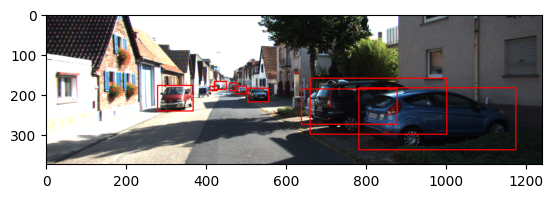

In [ ]:
import matplotlib.pyplot as plt

def visualize_labels(image_path, labels_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    with open(labels_path, 'r') as lf:
        labels = [line.strip().split() for line in lf.readlines()]

    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label)
        x_min = int((x_center - width / 2) * img_width)
        y_min = int((y_center - height / 2) * img_height)
        x_max = int((x_center + width / 2) * img_width)
        y_max = int((y_center + height / 2) * img_height)

        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    plt.imshow(img)
    plt.show()

# Example: Visualize a single image with labels
example_image = os.path.join(images_dir, '000096.png')  # Replace with an actual image name
example_labels = os.path.join(output_dir, '000096.txt')  # Replace with the corresponding label file

visualize_labels(example_image, example_labels)


###Preprocess UA-DETRAC Dataset